# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib as mpl

### Отключим предупреждения Anaconda

In [3]:
warnings.simplefilter('ignore')

# Загрузим данные

In [59]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X_new.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

In [5]:
R=Xdata_numpy['X']

In [6]:
max(R[0,:,8])

0.7076180398911479

In [7]:
R.shape

(35, 206, 52)

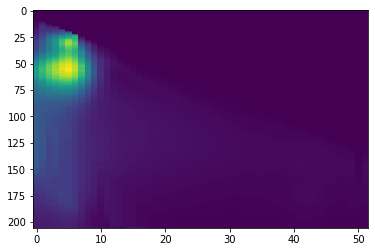

In [336]:
plt.imshow(R[0], aspect='auto')
plt.show()

In [ ]:
R*=10

In [103]:
u=np.load('dorrit.npz')

In [104]:
u['EEM'].shape

(27, 121, 24)

In [105]:
u.files

['EEM', 'Em', 'Ex', 'Y', 'columns', 'samples']

In [106]:
u['Em']

array([241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265,
       267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291,
       293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317,
       319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343,
       345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369,
       371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395,
       397, 399, 401, 403, 405, 407, 409, 411, 413, 415, 417, 419, 421,
       423, 425, 427, 429, 431, 433, 435, 437, 439, 441, 443, 445, 447,
       449, 451, 453, 455, 457, 459, 461, 463, 465, 467, 469, 471, 473,
       475, 477, 479, 481], dtype=uint16)

In [107]:
u['Ex']

array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315],
      dtype=uint16)

In [148]:
#d=np.load('dorrit2_2021-11-18.npz') #http://models.life.ku.dk/dorrit

In [149]:
d=np.load('fluordata_2021-11-18.npz') #http://models.life.ku.dk/Fluorescence

In [5]:
#d=np.load('2021-11-17.npz')

In [6]:
dir(d)

['__abstractmethods__',
 '__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_files',
 'allow_pickle',
 'close',
 'f',
 'fid',
 'files',
 'get',
 'items',
 'iteritems',
 'iterkeys',
 'keys',
 'pickle_kwargs',
 'values',
 'zip']

In [150]:
d.files

['EEM', 'EEM2', 'Em', 'Ex', 'columns', 'Y']

In [90]:
d['columns']

ValueError: Object arrays cannot be loaded when allow_pickle=False

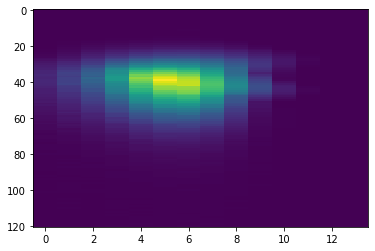

In [10]:
plt.imshow(d['EEM'][0,:,10:], aspect='auto')
plt.show()

In [37]:
d['EEM'][0,20:60,10:]

array([[ 7.79472861e-01,  4.07660965e+00,  9.18069439e+00,
         1.49107996e+01,  2.00990523e+01,  2.35464144e+01,
         2.38849442e+01,  2.02001523e+01,  1.28122020e+01,
         4.05576189e+00,  0.00000000e+00,  0.00000000e+00,
         3.10000000e-02,  0.00000000e+00],
       [ 1.15427765e+00,  5.90524435e+00,  1.31407835e+01,
         2.10226741e+01,  2.80015636e+01,  3.26234679e+01,
         3.32908994e+01,  2.89994844e+01,  2.01039605e+01,
         8.78371292e+00,  3.70000000e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.67929891e+00,  8.13200207e+00,  1.79803104e+01,
         2.84774391e+01,  3.76696913e+01,  4.37129038e+01,
         4.47329334e+01,  3.96859646e+01,  2.90515772e+01,
         1.50372112e+01,  3.60000000e-02,  1.41000000e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 2.51457429e+00,  1.08222546e+01,  2.37694574e+01,
         3.74071089e+01,  4.92949557e+01,  5.69907781e+01,
         5.83158340e+01,  5.22598330e+01,  3.

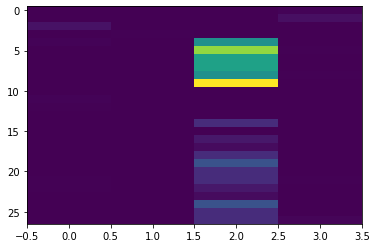

In [10]:
plt.imshow(d['Y'], aspect='auto')
plt.show()

In [48]:
d['Y'][:,2]*1e6

array([266754.78859397, 856604.02616486, 171299.38185826, 759917.29439193,
       772605.61931689, 740583.37147653, 702795.44332516, 664702.94278042,
       259735.68773043, 961953.09816176, 727376.8491832 , 897682.35038719,
       674574.79774021, 377887.51277185, 187473.42522693, 141153.36200848,
        91834.76367616, 126974.69093837, 791241.43097215, 397262.57636357,
       299578.28188708, 453762.23963467, 611320.9960422 , 231090.6399689 ,
       505477.2309195 , 474924.16073146, 492251.79283167, 549085.67609527,
       596059.29179088,  73641.28649351,  50644.61363145, 873820.59638549,
       912236.25302518, 313326.58984684, 417810.29484628, 203945.43927614,
       111810.48154685, 243134.50808768, 643015.24667098, 289637.52363779,
       987766.08706612, 712803.58824151, 921930.92450543, 807250.13638948,
        21419.88894073, 588374.07481769, 429749.53533121, 193020.42034542,
        31690.2316481 , 349854.02380698, 371052.8096417 , 941597.22570475,
        10049.34778757, 9

In [8]:
d['Em']

array([250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.,
       261., 262., 263., 264., 265., 266., 267., 268., 269., 270., 271.,
       272., 273., 274., 275., 276., 277., 278., 279., 280., 281., 282.,
       283., 284., 285., 286., 287., 288., 289., 290., 291., 292., 293.,
       294., 295., 296., 297., 298., 299., 300., 301., 302., 303., 304.,
       305., 306., 307., 308., 309., 310., 311., 312., 313., 314., 315.,
       316., 317., 318., 319., 320., 321., 322., 323., 324., 325., 326.,
       327., 328., 329., 330., 331., 332., 333., 334., 335., 336., 337.,
       338., 339., 340., 341., 342., 343., 344., 345., 346., 347., 348.,
       349., 350., 351., 352., 353., 354., 355., 356., 357., 358., 359.,
       360., 361., 362., 363., 364., 365., 366., 367., 368., 369., 370.,
       371., 372., 373., 374., 375., 376., 377., 378., 379., 380., 381.,
       382., 383., 384., 385., 386., 387., 388., 389., 390., 391., 392.,
       393., 394., 395., 396., 397., 398., 399., 40

In [202]:
d['C'].shape

(64, 4)

In [49]:
d['Y'][:,0]

array([2.38759807e-01, 3.50027392e-01, 7.50158846e-01, 3.65907241e-02,
       7.07174541e-01, 4.92038964e-01, 8.84651325e-01, 1.53072737e-01,
       3.64543663e-01, 2.18330865e-01, 6.92781188e-01, 6.21159523e-01,
       5.30562832e-01, 1.28841297e-01, 3.07175617e-01, 2.21607507e-01,
       8.73439820e-01, 1.20057423e-01, 6.08219566e-01, 7.29354981e-01,
       9.37350677e-02, 2.84140654e-01, 7.37548675e-02, 7.77061374e-01,
       8.34367731e-01, 7.36620923e-01, 4.97072712e-02, 4.43610397e-01,
       9.14771435e-01, 6.70525799e-01, 3.77300865e-01, 2.59572465e-02,
       5.72055219e-01, 8.97075061e-01, 8.21533180e-01, 5.47907950e-01,
       6.78129672e-01, 9.24572068e-01, 8.10016002e-01, 3.34182324e-01,
       6.32141359e-01, 5.12126470e-01, 5.93537556e-01, 8.55362465e-01,
       5.31971924e-01, 1.98289996e-01, 6.43978952e-01, 3.18832406e-01,
       9.80055319e-01, 9.47808710e-01, 4.75748832e-01, 4.28477907e-01,
       2.80043325e-01, 4.14579871e-01, 9.90129007e-01, 1.05224368e-01,
      

In [50]:
d['B0'].shape

(351, 4)

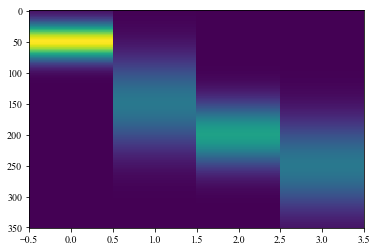

In [51]:
plt.imshow(d['B0'], aspect='auto')
plt.show()

# N-PLS1
## Приближение к правильному алгоритму
### Опишу ка я центрирование в виде класса, для удобства.

In [8]:
import  subprocess
import sys
import os
from N_PLS1_help_scripts.CenteringClass import centrir
from N_PLS1_help_scripts.N_PLS1_algorithm import Tri_PLS1_grid

In [14]:
t=centrir()

In [13]:
#a=t.centering_and_cv(Xdata_numpy['X'],Ydata)

In [14]:
#Xdata_numpy['excitation']

In [15]:
#Xdata_numpy['emission']

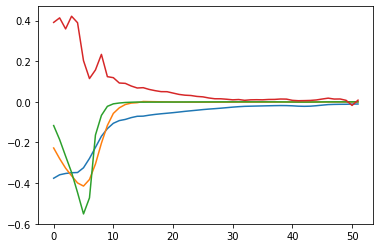

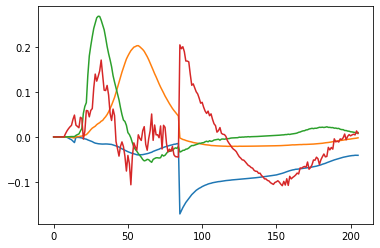

In [19]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])
# для гуминовых веществ может иметь смысл взять чуть больше компонент;
# для аминокислот должно быть достаточно одного
model = Tri_PLS1_grid(n_components=4, a=0.3)

# NB: здесь мы ничего не центрируем, что как будто не влияет на результат
X = Xdata_numpy['X']
#X=X_setting.copy()
#X -= X.mean(axis = 0) # раскомментировать для центрирования по X

y0 = Ydata.to_numpy()[:,0] # здесь номер колонки выбирает гуминовые вещества / тирозин / триптофан

st=np.std(y0)
#y0 -= y0.mean() # раскомментировать для центрирования по 
#y0 /= (st**2)
model.fit(X[:25,:,:], y0[:25])

# почему-то массивы w_i, w_k оказываются трёхмерными, но последняя размерность всегда 1
# уберём её, чтобы работать, как мы обычно работаем с матрицами
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(model.w_i).transpose())

plt.figure()
plt.plot(flatten(model.w_k).transpose())



In [20]:
y_=model.predict(10*X[25:,:,:])

In [21]:
model.score(10*X[25:,:,:],10*y0[25:])

0.7238566113720308

In [22]:
y_

array([386.21991838, 387.07135427, 328.12769537, 331.08689897,
       450.75904137, 484.21321674, 416.58036838, 526.69780828,
       353.5509063 , 400.06498316])

In [23]:
10*y0[20:]

array([341.93087595, 333.42049371, 410.39800505, 479.96256608,
       421.47702307, 342.42464211, 369.09159956, 281.83879154,
       214.11182093, 463.22119444, 443.99736516, 399.01820698,
       560.46636892, 353.98814855, 356.95793478])

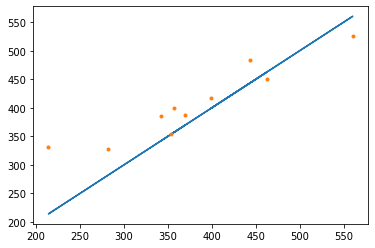

In [24]:
plt.plot(10*y0[25:],10*y0[25:])
plt.plot(10*y0[25:],y_,".")
plt.show();

# Центрируем данные Марата(замена: вместо 3-х методов теперь 2)

In [77]:
cen=centrir(testSize=0.1428,column_y=0)

In [78]:
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)

In [79]:
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

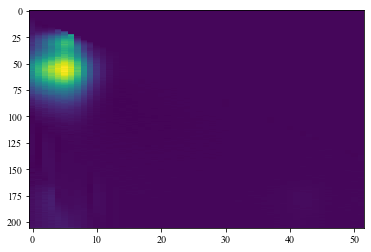

In [80]:
plt.imshow(X_train[12,:,:],aspect='auto')
plt.show()

In [64]:
Ydata.iloc[:,0]

0     45.446791
1     53.715968
2     39.837588
3     31.410666
4     42.444629
5     36.479939
6     36.112553
7     44.049334
8     35.354605
9     47.441840
10    47.577334
11    38.622683
12    44.546831
13    35.724431
14    54.640664
15    49.409746
16    26.197475
17    36.226228
18    43.272738
19    34.070473
20    34.193088
21    33.342049
22    41.039801
23    47.996257
24    42.147702
25    34.242464
26    36.909160
27    28.183879
28    21.411182
29    46.322119
30    44.399737
31    39.901821
32    56.046637
33    35.398815
34    35.695793
Name: Gominy, dtype: float64

# Центрированная кроссвалидация для fluordata_2021-11-18

In [152]:
X=d['EEM2'][:,:,3:]

In [153]:
y=d['Y'][:,2]

In [154]:
X -= X.mean(axis = 0)

In [155]:
y*=1e6

In [156]:
aaa=y.mean()

In [157]:
y -= y.mean()

In [158]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1428, random_state=42)

# Центрированная кроссвалидация для dorrit2

In [122]:
X=d['EEM'][:,:,10:]

In [123]:
y=d['Y'][:,0]

In [124]:
X -= X.mean(axis = 0)

In [125]:
aaa=y.mean()

In [126]:
y -= y.mean()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1428, random_state=42)

In [128]:
y

array([-20.26851852, -20.26851852, 254.73148148, -20.26851852,
        25.73148148,  -3.26851852,  -0.26851852, -10.26851852,
       -14.26851852, -20.26851852, -20.26851852,  35.73148148,
         7.73148148, -20.26851852, -20.26851852, -20.26851852,
       -16.76851852, -16.76851852, -16.76851852, -18.51851852,
       -19.39351852,   7.73148148,   7.73148148,  -6.26851852,
       -19.39351852, -18.51851852, -16.76851852])

# Центрированная кроссвалидация для 2021-11-17.npz

In [29]:
d['Y'].shape

(64, 4)

In [30]:
#X=d['X'][:,100:,24:]
X=d['X']

In [31]:
X*=1e7

In [32]:
y=d['Y'][:,2]

In [33]:
y

array([0.26675479, 0.85660403, 0.17129938, 0.75991729, 0.77260562,
       0.74058337, 0.70279544, 0.66470294, 0.25973569, 0.9619531 ,
       0.72737685, 0.89768235, 0.6745748 , 0.37788751, 0.18747343,
       0.14115336, 0.09183476, 0.12697469, 0.79124143, 0.39726258,
       0.29957828, 0.45376224, 0.611321  , 0.23109064, 0.50547723,
       0.47492416, 0.49225179, 0.54908568, 0.59605929, 0.07364129,
       0.05064461, 0.8738206 , 0.91223625, 0.31332659, 0.41781029,
       0.20394544, 0.11181048, 0.24313451, 0.64301525, 0.28963752,
       0.98776609, 0.71280359, 0.92193092, 0.80725014, 0.02141989,
       0.58837407, 0.42974954, 0.19302042, 0.03169023, 0.34985402,
       0.37105281, 0.94159723, 0.01004935, 0.97438216, 0.3313195 ,
       0.44704622, 0.82770888, 0.6402179 , 0.53247606, 0.88152482,
       0.5265866 , 0.84122958, 0.5626152 , 0.1025782 ])

In [34]:
X -= X.mean(axis = 0)

In [35]:
y*=1e1

In [36]:
y

array([2.66754789, 8.56604026, 1.71299382, 7.59917294, 7.72605619,
       7.40583371, 7.02795443, 6.64702943, 2.59735688, 9.61953098,
       7.27376849, 8.9768235 , 6.74574798, 3.77887513, 1.87473425,
       1.41153362, 0.91834764, 1.26974691, 7.91241431, 3.97262576,
       2.99578282, 4.5376224 , 6.11320996, 2.3109064 , 5.05477231,
       4.74924161, 4.92251793, 5.49085676, 5.96059292, 0.73641286,
       0.50644614, 8.73820596, 9.12236253, 3.1332659 , 4.17810295,
       2.03945439, 1.11810482, 2.43134508, 6.43015247, 2.89637524,
       9.87766087, 7.12803588, 9.21930925, 8.07250136, 0.21419889,
       5.88374075, 4.29749535, 1.9302042 , 0.31690232, 3.49854024,
       3.7105281 , 9.41597226, 0.10049348, 9.74382158, 3.31319499,
       4.47046216, 8.27708876, 6.40217897, 5.3247606 , 8.81524818,
       5.265866  , 8.41229579, 5.62615203, 1.02578203])

In [37]:
max(y),min(y)

(9.877660870661202, 0.10049347787571605)

In [38]:
y -= y.mean()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1428, random_state=42)

In [40]:
y

array([-2.3248318 ,  3.57366058, -3.27938586,  2.60679326,  2.73367651,
        2.41345403,  2.03557475,  1.65464975, -2.3950228 ,  4.6271513 ,
        2.28138881,  3.98444382,  1.7533683 , -1.21350455, -3.11764543,
       -3.58084606, -4.07403204, -3.72263277,  2.92003463, -1.01975392,
       -1.99659686, -0.45475728,  1.12083028, -2.68147328,  0.06239263,
       -0.24313807, -0.06986175,  0.49847708,  0.96821324, -4.25596682,
       -4.48593354,  3.74582628,  4.12998285, -1.85911378, -0.81427673,
       -2.95292529, -3.87427487, -2.5610346 ,  1.43777279, -2.09600444,
        4.88528119,  2.1356562 ,  4.22692956,  3.08012168, -4.77818079,
        0.89136107, -0.69488433, -3.06217548, -4.67547736, -1.49383944,
       -1.28185158,  4.42359258, -4.8918862 ,  4.7514419 , -1.67918469,
       -0.52191752,  3.28470908,  1.40979929,  0.33238092,  3.8228685 ,
        0.27348632,  3.41991611,  0.63377234, -3.96659765])

## Делаем нецентрированную кроссвалидацию на данных Марата

In [293]:
from N_PLS1_help_scripts.Crosswal_With_Out_Centering import crossval

In [294]:
dat=crossval(testSize=0.1428,column_y=0).crosswal(Xdata_numpy['X'],Ydata)

In [295]:
y_train=dat.y_train
y_test=dat.y_test
X_train=dat.X_train
X_test=dat.X_test

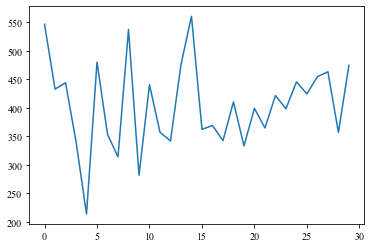

In [296]:
plt.plot(y_train)
plt.show()

# Нецентрированная кроссвалидация flourdata_2021-11-18

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    d['EEM2'][:,:,3:], d['Y'][:,5]*1e6, test_size=0.1428, random_state=42)

# Нецентрированная кроссвалидация dorrit

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    d['EEM'][:,:,10:], d['Y'][:,3], test_size=0.1428, random_state=42)

In [24]:
d['Y'][:,3]

array([ 55. , 220. ,   0. ,   0. ,  18. ,  28. ,   8. ,  16. ,  28. ,
         0. ,   0. ,   0. ,   0. ,   5. ,   0. ,   0. ,  20. ,  20. ,
        10. ,   5. ,   2.5,  40. ,  20. ,  20. ,   2.5,   5. ,  80. ])

# Нецентрированная кроссвалидация для 2021-11-17.npz

In [272]:
X_train, X_test, y_train, y_test = train_test_split(
    d['X'][:,100:,24:]*1e7, d['Y'][:,3]*1e1, test_size=0.1428, random_state=42)

In [ ]:
[:,:,20:]

In [76]:
X_train.shape

(54, 351, 17)

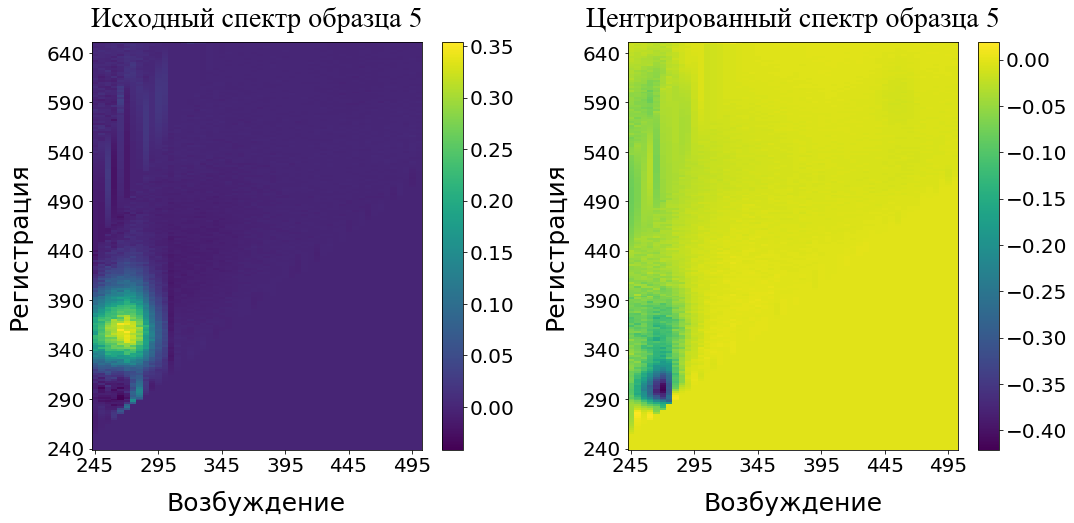

In [41]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(17, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0, 0])
plt.imshow(Xdata_numpy['X'][4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Исходный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(195,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[0, 1])
plt.imshow(X_train[4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Центрированный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(195,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('centering.png', format='png', dpi=300)
plt.savefig("centering.svg", format="svg")

plt.show();

In [769]:
y_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_test']
y_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_train']
X_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_train']
X_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_test']

# Делаем применение сразу по всем компонентам

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, make_scorer
import sklearn

In [159]:
npls1=Tri_PLS1_grid()
scoring={'mse': make_scorer(mean_squared_error),'r2':'r2'}
parametrsNames={'n_components': range(1,21),
                'a': [0.09]}

In [160]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=5, scoring=scoring,refit='r2', return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
mse_cv=gridCought.cv_results_[ "mean_test_mse" ]
mse_c=gridCought.cv_results_[ "mean_train_mse" ]
r2_cv=gridCought.cv_results_[ "mean_test_r2" ]
r2_c=gridCought.cv_results_[ "mean_train_r2" ]
#predictors=gridCought.predict(X_test.copy())

Wall time: 1min 13s


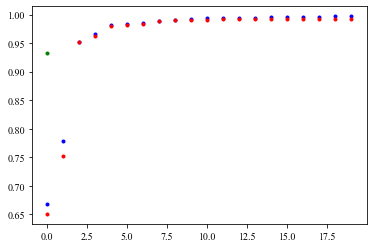

In [161]:
plt.plot(r2_p,".",color='green')
plt.plot(r2_c,".",color='blue')
plt.plot(r2_cv,".",color='red')
plt.show()

In [162]:
r2_cv

array([0.65095642, 0.75271302, 0.95150831, 0.96258896, 0.97927921,
       0.98209811, 0.98378003, 0.9877915 , 0.98961028, 0.99044624,
       0.99120501, 0.99173368, 0.9917672 , 0.99205421, 0.99206879,
       0.99181325, 0.99182328, 0.99196475, 0.99135718, 0.99162355])

In [34]:
d['Y'][:,3]

array([ 55. , 220. ,   0. ,   0. ,  18. ,  28. ,   8. ,  16. ,  28. ,
         0. ,   0. ,   0. ,   0. ,   5. ,   0. ,   0. ,  20. ,  20. ,
        10. ,   5. ,   2.5,  40. ,  20. ,  20. ,   2.5,   5. ,  80. ])

In [80]:
gridCought.predict(Xdata_numpy['X'].copy())

array([39.13383478, 41.56979849, 23.24656652, 23.23515833, 29.84260094,
       22.94702305, 25.59509719, 40.49997294, 23.80170191, 28.46482685,
       33.92056993, 32.55958196, 32.17599206, 25.72100398, 46.07842597,
       36.0285153 , 16.48290184, 24.51332927, 37.76418532, 23.47839282,
       27.55076219, 24.33129841, 28.23762912, 37.43769137, 37.51010633,
       25.87484715, 28.97252524, 21.74525965, 18.56624709, 38.23456636,
       36.4899954 , 31.20348147, 42.68496473, 23.06156703, 28.15595184])

In [163]:
#asmund
R=d['EEM2'][:,:,3:].copy()
MM=R.mean(axis = 0)
R-=MM
predict=gridCought.predict(R)
predict+=aaa

In [166]:
tt=d['Y'][:,2]*1e6

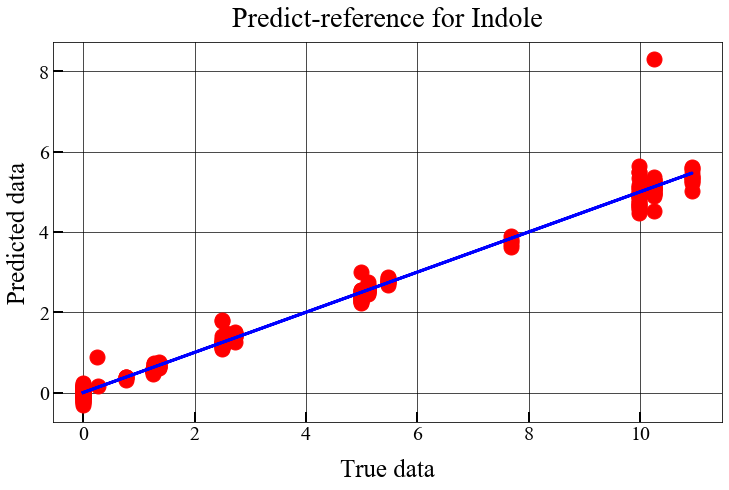

In [170]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(tt,predict,".",color="red",ms=30)
axs.plot(tt,tt,color="blue",lw=3)
#axs.set_ylim(ymin=-2,ymax=60)
#axs.set_xlim(xmin=-2,xmax=60)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Predicted data" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("True data",  fontsize=25,labelpad=15)
axs.set_title("Predict-reference for Indole", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels([i for i in range(-2,12,2)], fontsize=20)
axs.set_yticklabels([i for i in range(-2,12,2)], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('N-PLS1_predict_reference_asmund_indole.png', format='png', dpi=300)
plt.savefig("N-PLS1_predict_reference_asmund_indole.svg", format="svg")
plt.show();

In [133]:
#dorrit
R=X.copy()
MM=R.mean(axis = 0)
R-=MM
predict=gridCought.predict(R)
predict+=aaa

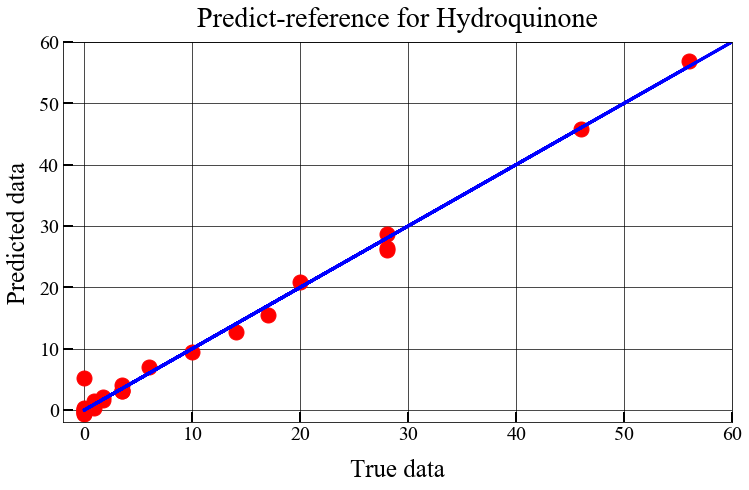

In [147]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(d['Y'][:,0],predict,".",color="red",ms=30)
axs.plot(d['Y'][:,0], d['Y'][:,0],color="blue",lw=3)
axs.set_ylim(ymin=-2,ymax=60)
axs.set_xlim(xmin=-2,xmax=60)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Predicted data" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("True data",  fontsize=25,labelpad=15)
axs.set_title("Predict-reference for Hydroquinone", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels([i for i in range(-10,70,10)], fontsize=20)
axs.set_yticklabels([i for i in range(-10,70,10)], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('N-PLS1_predict_reference_dorrit_hydroquinone_before_60.png', format='png', dpi=300)
plt.savefig("N-PLS1_predict_reference_dorrit_hydroquinone_before_60.svg", format="svg")
plt.show();

In [106]:
#marat
R=Xdata_numpy['X'].copy()
MM=R.mean(axis = 0)
R-=MM
uu=Ydata.iloc[:,0].to_numpy()
um=uu.mean()

predict=gridCought.predict(R)
predict+=um

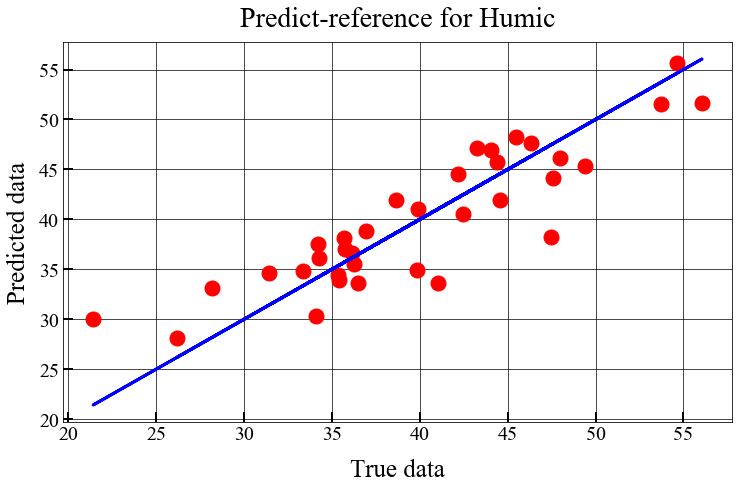

In [112]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(uu,predict,".",color="red",ms=30)
axs.plot(uu,uu,color="blue",lw=3)
#axs.set_ylim(ymin=0,ymax=100)
#axs.set_xlim(xmin=0,xmax=100)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Predicted data" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("True data",  fontsize=25,labelpad=15)
axs.set_title("Predict-reference for Humic", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels([i for i in range(15,60,5)], fontsize=20)
axs.set_yticklabels([i for i in range(15,60,5)], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('N-PLS1_predict_reference_marat_humic.png', format='png', dpi=300)
plt.savefig("N-PLS1_predict_reference_marat_humic.svg", format="svg")
plt.show();

In [ ]:
#Now we can quiqly build not wery bad predict-reference plots

In [16]:
from Build_plots.Predict_reference import PR_plts

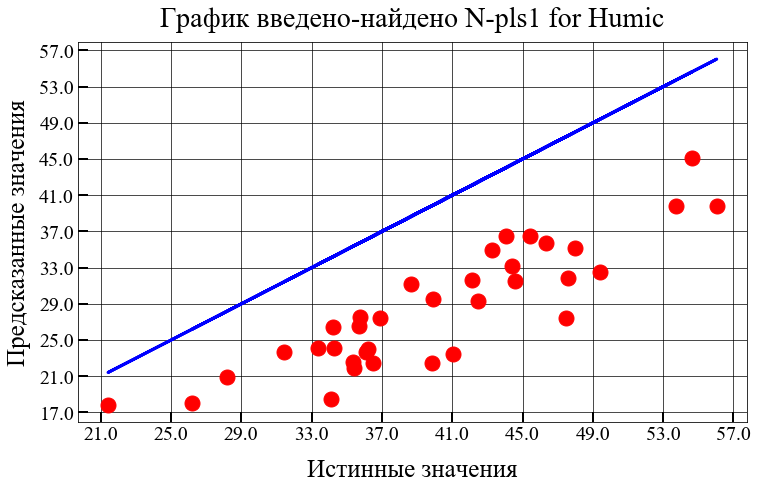

In [17]:
a=PR_plts(rounding_long=0)
t=a.main(Ydata.iloc[:,0],gridCought.predict(Xdata_numpy['X'].copy()))

In [22]:
del(a)

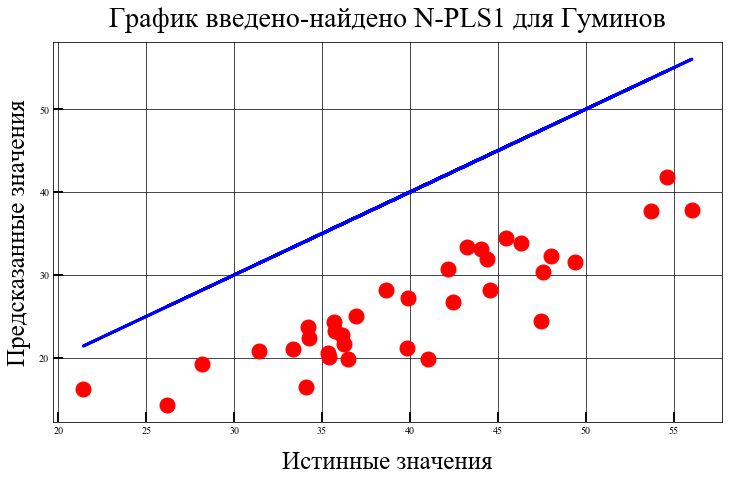

In [105]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(Ydata.iloc[:,0],gridCought.predict(Xdata_numpy['X'].copy()),".",color="red",ms=30)
axs.plot(Ydata.iloc[:,0],Ydata.iloc[:,0],color="blue",lw=3)
#axs.set_ylim(ymin=0,ymax=100)
#axs.set_xlim(xmin=0,xmax=100)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 для Гуминов", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.set_xticklabels([i for i in range(15,60,5)], fontsize=20)
#axs.set_yticklabels([i for i in range(15,60,5)], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
#plt.savefig('График введено-найдено N-PLS1 Р.png', format='png', dpi=300)
#plt.savefig("График введено-найдено N-PLS1 Р.svg", format="svg")
plt.show();

In [31]:
predictors

array([34.96029295,  5.75854661, -1.87895617, 39.64235822])

In [28]:
r2_p

0.9510755004859347

In [29]:
max(r2_cv)

0.8786471332516033

In [323]:
r2_c

array([-0.18615361,  0.46934166,  0.80440999,  0.9321769 ,  0.95344018,
        0.95716787,  0.96364735,  0.98603224,  0.99346951])

In [324]:
r2_cv

array([-2.71025434, -3.49132672, -3.03919439, -1.85296537, -0.30944658,
       -1.68322151, -4.7461568 , -0.42265626, -2.24890472])

In [259]:
r2_cv

array([-0.93564096, -1.83415258, -0.20950518,  0.84372076,  0.70139467,
        0.82887371,  0.75844266,  0.74592558,  0.69735276])

In [23]:
%matplotlib inline

In [24]:
from decimal import Decimal

In [25]:
def sett(st,end,num):
    li=list()
    step=int(((end-st)/num))
    for i in range(st,end+step,step):
        li.append(Decimal((i/100)).quantize(Decimal("1.00")))
    return li

In [26]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

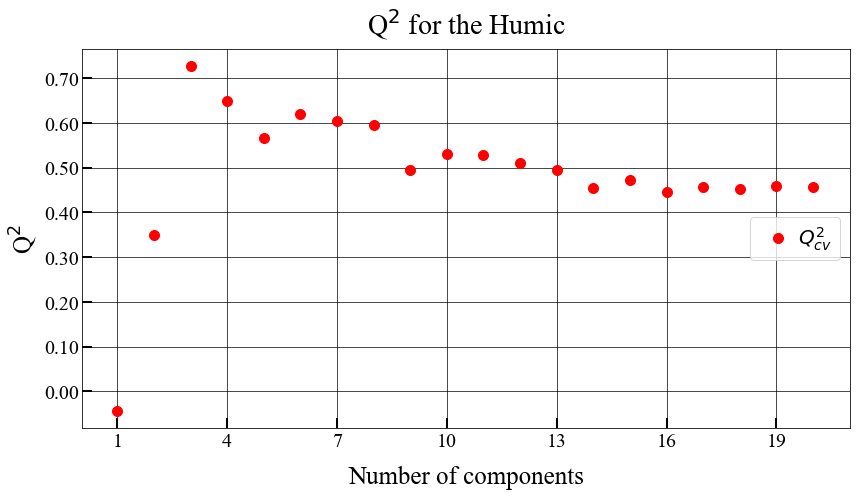

In [89]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv,".",color="red",ms=20,label='$Q_{cv}^{2}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')
#plt.semilogy()
#axs.set_ylim(ymin=0,ymax=1)
axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks([0.999996,0.999997,0.999998,0.999999,1.00])
#axs.set_yticks(np.linspace(0.98,1,num=3))

axs.set_ylabel('Q$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Number of components",  fontsize=25,labelpad=15)
axs.set_title("Q$^{2}$ for the Humic", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
axs.set_yticklabels(sett(-10,70,8), fontsize=20)
#axs.set_yticklabels(['0.999996','0.999997','0.999998','0.999999','1.00','0.70','0.80','0.60','1.00'], fontsize=20)
#axs.set_yticklabels(['0.992','0.992','0.994','0.996','0.998','1.000','0.80','0.60','1.00'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_marat_humic_with_centr_Q.png', format='png', dpi=300)
plt.savefig("N-PLS1_marat_humic_with_centr_Q.svg", format="svg")


plt.show();

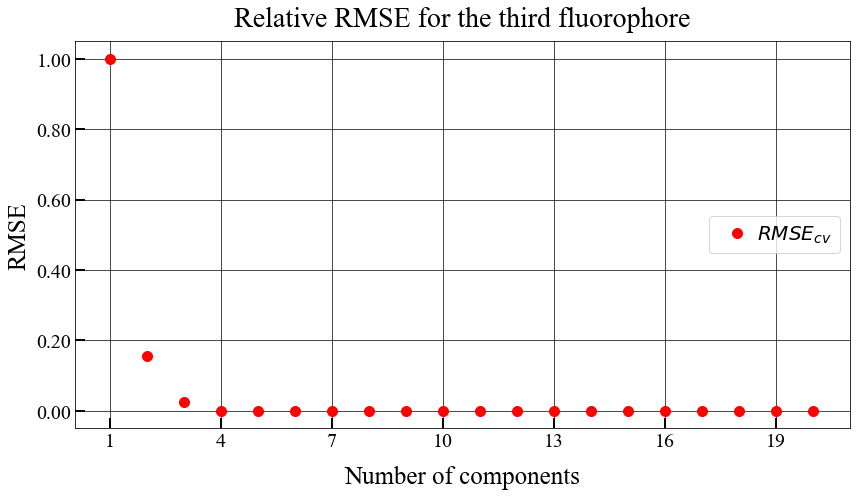

In [63]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot((mse_cv**0.5)/max(mse_cv**0.5),".",color="red",ms=20,label='$RMSE_{cv}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(0.30,0.45,num=6))

axs.set_ylabel('RMSE',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Number of components",  fontsize=25,labelpad=15)
axs.set_title("Relative RMSE for the third fluorophore", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
axs.set_yticklabels(sett(-20,100,6), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_Synthetic_third_fl_with_centr_otn_RMSE.png', format='png', dpi=300)
plt.savefig("N-PLS1_Synthetic_third_fl_with_centr_otn_RMSE.svg", format="svg")


plt.show();

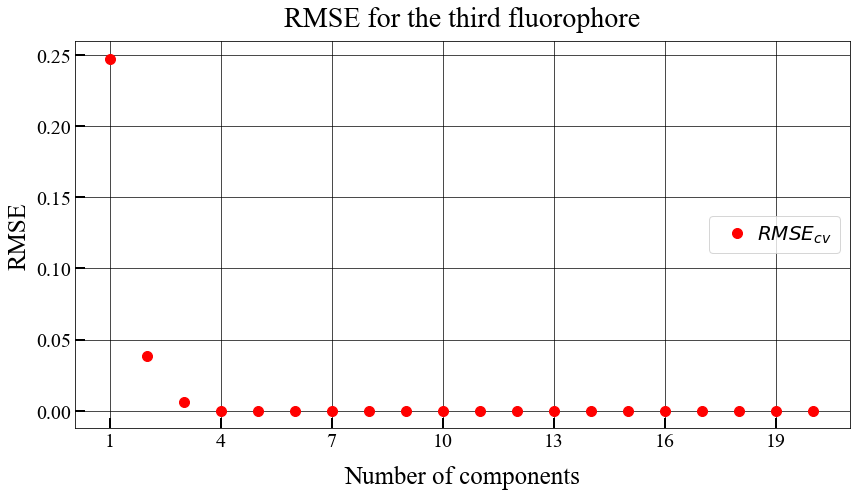

In [66]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot((mse_cv**0.5),".",color="red",ms=20,label='$RMSE_{cv}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(0.30,0.45,num=6))

axs.set_ylabel('RMSE',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Number of components",  fontsize=25,labelpad=15)
axs.set_title("RMSE for the third fluorophore", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
axs.set_yticklabels(sett(-5,25,6), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_Synthetic_third_fl_with_centr_RMSE.png', format='png', dpi=300)
plt.savefig("N-PLS1_Synthetic_third_fl_with_centr_RMSE.svg", format="svg")


plt.show();

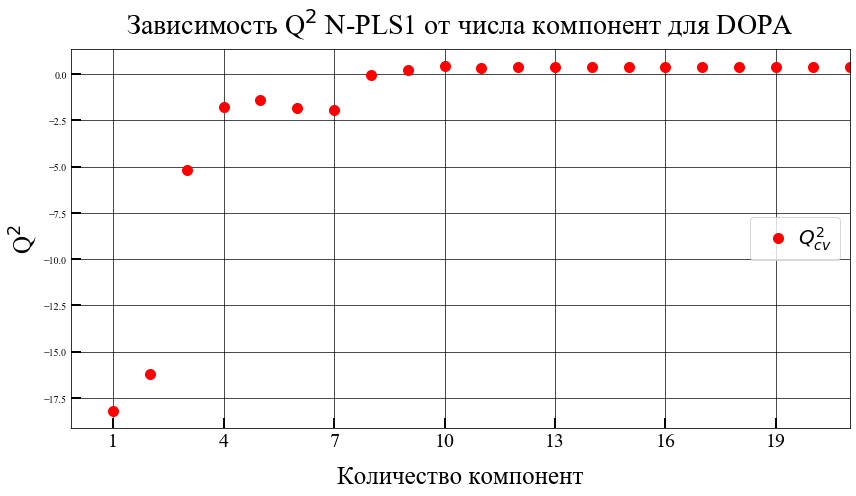

In [53]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv,".",color="red",ms=20,label='$Q_{cv}^{2}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')
#plt.semilogy()
#axs.set_ylim(ymin=0.6,ymax=1)
axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks([0.999996,0.999997,0.999998,0.999999,1.00])
#axs.set_yticks(np.linspace(0.98,1,num=3))

axs.set_ylabel('Q$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость Q$^{2}$ N-PLS1 от числа компонент для DOPA", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
#axs.set_yticklabels(sett(60,100,8), fontsize=20)
#axs.set_yticklabels(['0.999996','0.999997','0.999998','0.999999','1.00','0.70','0.80','0.60','1.00'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

#plt.savefig('N-PLS1_DOPA_no_centr_Q_from_zero.png', format='png', dpi=300)
#plt.savefig("N-PLS1_DOPA_no_centr_Q_from_zero.svg", format="svg")


plt.show();

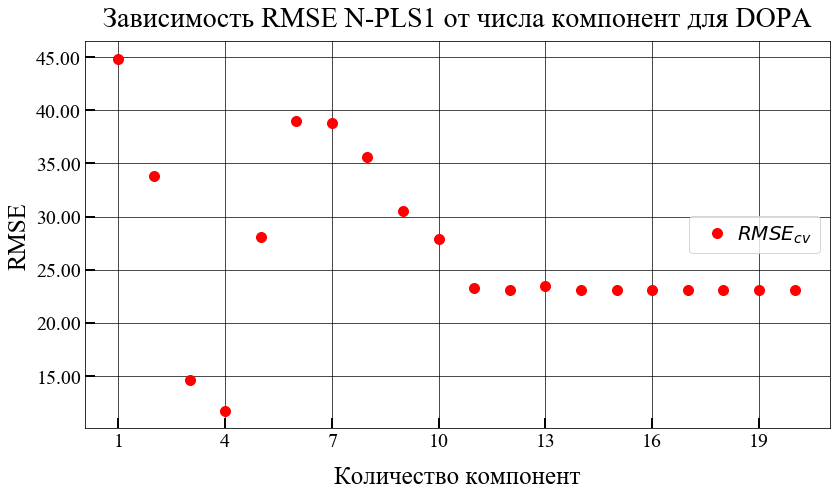

In [306]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(mse_cv**0.5,".",color="red",ms=20,label='$RMSE_{cv}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(0.30,0.45,num=6))

axs.set_ylabel('RMSE',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость RMSE N-PLS1 от числа компонент для DOPA", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
axs.set_yticklabels(sett(1000,5000,8), fontsize=20)
#axs.set_yticklabels(['0','0.000','0.001','0.002','0.003','0.004','0.005','0.006'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_DOPA_no_centering_RMSE.png', format='png', dpi=300)
plt.savefig("N-PLS1_DOPA_no_centering_RMSE.svg", format="svg")


plt.show();

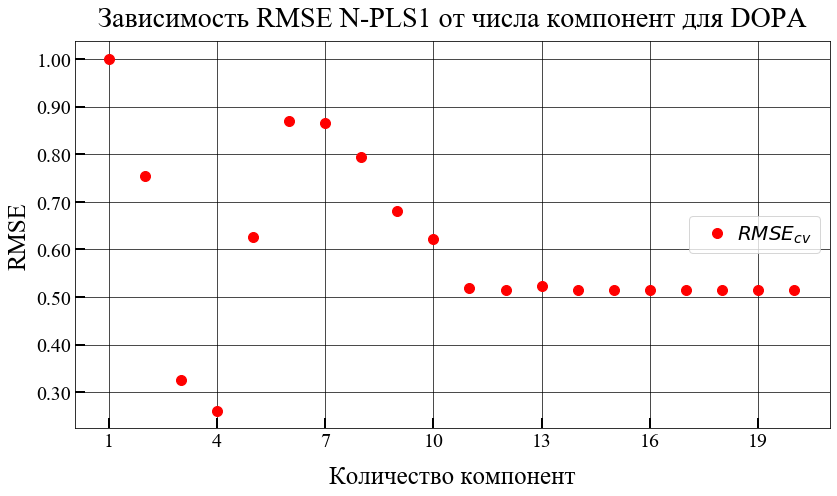

In [308]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot((mse_cv**0.5)/max(mse_cv**0.5),".",color="red",ms=20,label='$RMSE_{cv}$')
#axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
#axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,22,3)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(0.30,0.45,num=6))

axs.set_ylabel('RMSE',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость RMSE N-PLS1 от числа компонент для DOPA", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,23,3), fontsize=20)
axs.set_yticklabels(sett(20,100,8), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=7,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=20) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1_DOPA_no_with_otn_RMSE.png', format='png', dpi=300)
plt.savefig("N-PLS1_DOPA_no_with_otn_RMSE.svg", format="svg")


plt.show();

In [309]:
pkl.dump(
	{'Qcv': r2_cv, 'Qc': r2_c, 'Qp': r2_p,
     'RMSEcv':mse_cv**0.5, 'RMSEc': mse_c**0.5, 
     'RMSEcv_otn':(mse_cv**0.5)/max(mse_cv**0.5)
    },
	open('DOPA_N-PLS1_no_19_11_2021.pkl.gz', 'wb')
)

In [92]:
r2_cv[-1]

-0.10467465523281833

In [86]:
mse_cv

array([156.98736489,  72.10981779,  23.3943777 ,  29.38198601,
        38.80622751,  33.99437696,  27.84935082,  25.98631831,
        26.25255445,  33.53378232,  39.37478071,  45.49351442,
        45.24959053,  47.85891285,  47.34191628,  47.10221761])

In [316]:
min(mse_cv**0.5)

0.26035695639620177

In [126]:
ff={'r':r2_cv, 'mse':mse_cv**0.5}

In [197]:
r2_cv=ff['r']
mse_cv=ff['mse']**2

In [57]:
y_test

array([ 2.1530446 , -4.27022686,  2.44997086, 14.64600637, -3.88210493])

NameError: name 'predictors' is not defined

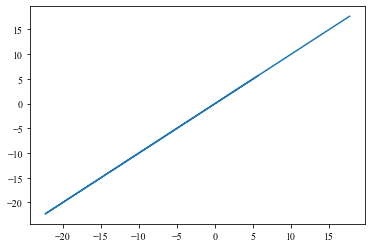

In [24]:
plt.plot(y_test,y_test)
plt.plot(y_test,predictors,".",color="red")
plt.show();

In [ ]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(yTest,n_predictors,".",color="red",ms=40)
axs.plot(yTest,yTest,color="blue",lw=5)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 Триптофана 1 компонента", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['15','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','60'], fontsize=20)
axs.set_yticklabels(['15','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','60'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено N-PLS1 Trp 1 component.png', format='png', dpi=300)
plt.savefig("График введено-найдено N-PLS1 Trp 1 component.svg", format="svg")
plt.show();

In [24]:
b_npls1_full=gridCought.best_estimator_.b.reshape(206,55)

AttributeError: 'Tri_PLS1_grid' object has no attribute 'b'

In [67]:
gridCought.best_estimator_.w_i.shape

(5, 35, 1)

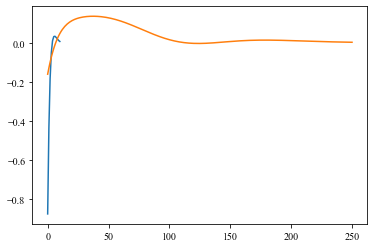

In [46]:
plt.plot(flatten(gridCought.best_estimator_.w_i)[3,:])
plt.plot(flatten(gridCought.best_estimator_.w_k)[3,:])
plt.show();

In [155]:
w_i=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Humic_N-PLS1_final_2_components.pkl.gz', 'rb'))['w_i_best_estimator']
w_k=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Humic_N-PLS1_final_2_components.pkl.gz', 'rb'))['w_k_best_estimator']

In [108]:
[i for i in range(239,502,2)][1::20]

[241, 281, 321, 361, 401, 441, 481]

In [102]:
len([i for i in range(248,484,2)])

118

In [156]:
d['Ex'][1:][[i for i in range(0,len(d['Ex'])-1,2)]]

array([235, 245, 255, 265, 275, 285, 295, 305, 315])

In [155]:
d['Ex'][1:]

array([235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295,
       300, 305, 310, 315, 320])

In [68]:
d['Ex'][22:][[i for i in range(0,len(d['Ex'])-22,2)]]

array([340., 350., 360., 370., 380., 390., 400.])

In [158]:
d['Em'][[i for i in range(-20,len(d['Em']),20)]]

array([461.95999146, 230.        , 270.        , 310.        ,
       350.        , 390.        , 430.        , 470.        ])

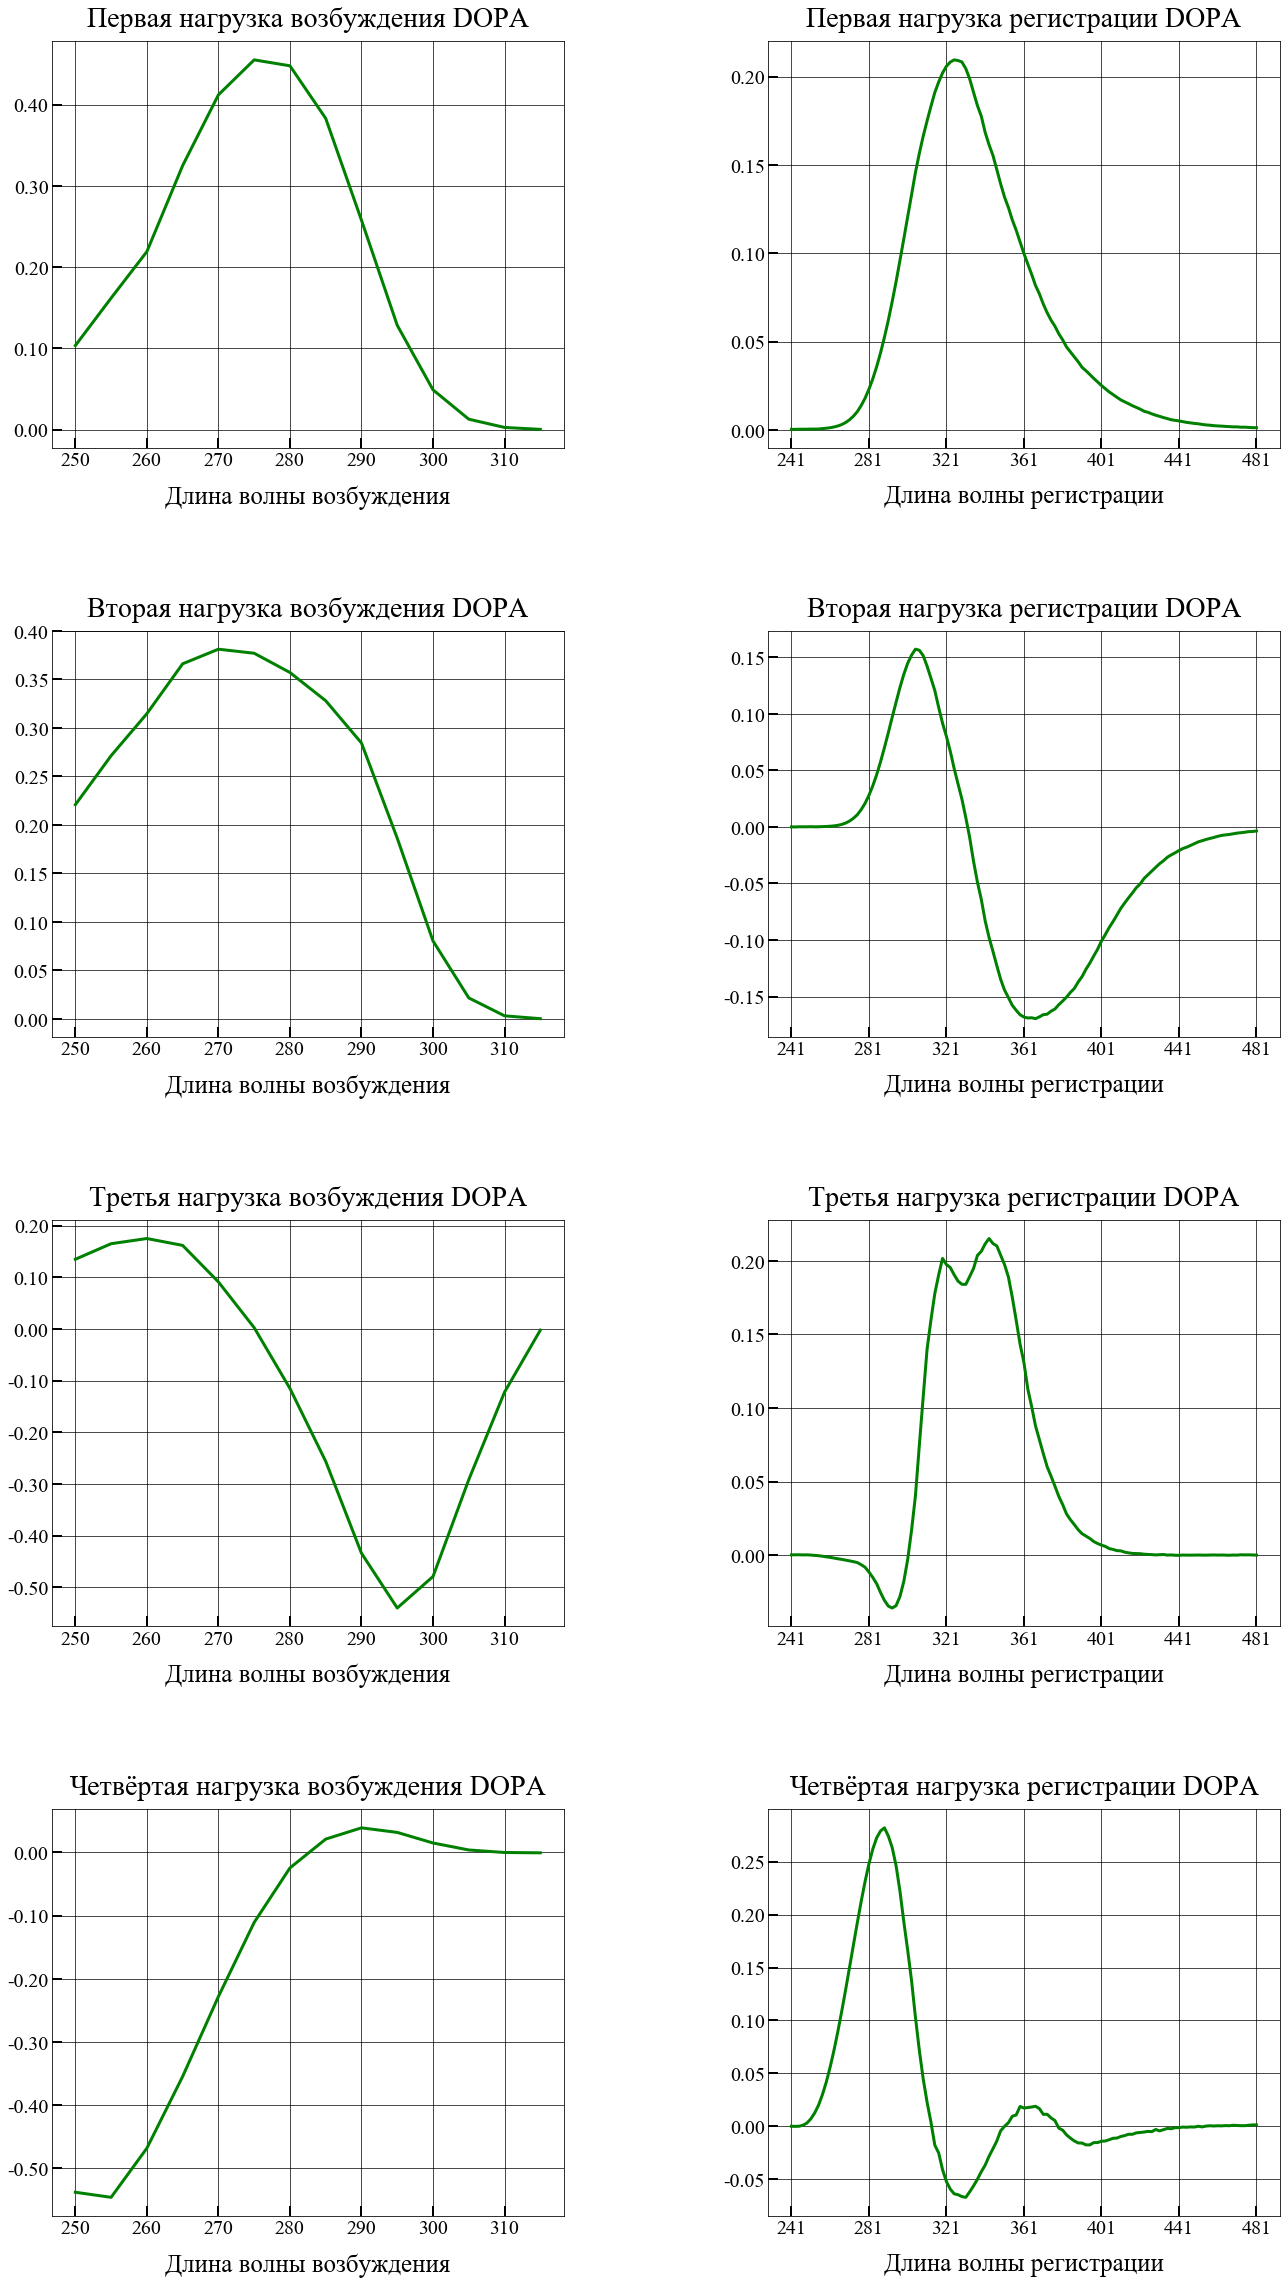

In [311]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(22, 40),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=4, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0.45)

fig_ax_1 = fg.add_subplot(gs[0,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_1.set_yticks(np.linspace(-0.40, 0.0, num = 5))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Первая нагрузка возбуждения DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels([i for i in range(200,320,5)][8::2], fontsize=20)
fig_ax_1.set_yticklabels(sett(-10,50,6), fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_1 = fg.add_subplot(gs[1,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,1],"-",color="green",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Вторая нагрузка возбуждения DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels([i for i in range(200,320,5)][8::2], fontsize=20)
fig_ax_1.set_yticklabels(sett(-5,40,9), fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_1 = fg.add_subplot(gs[2,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Третья нагрузка возбуждения DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels([i for i in range(200,320,5)][8::2], fontsize=20)
fig_ax_1.set_yticklabels(sett(-60,30,9), fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_1 = fg.add_subplot(gs[3,0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,3],"-",color="green",lw=3,label="4-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Четвёртая нагрузка возбуждения DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
fig_ax_1.set_xticklabels([i for i in range(200,320,5)][8::2], fontsize=20)
fig_ax_1.set_yticklabels(sett(-60,0,6), fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран












fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,0],"-",color="green",lw=3,label="1-st")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_2.set_yticks(np.linspace(-0.2, 0, num = 5))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Первая нагрузка регистрации DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
#fig_ax_2.set_xticklabels(d['Em'][50:][[i for i in range(0,len(d['Em'])-50,50)]], fontsize=20)
fig_ax_2.set_yticklabels(sett(-5,20,5), fontsize=20)
fig_ax_2.set_xticklabels([i for i in range(199,502,2)][1::20], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_2 = fg.add_subplot(gs[1, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,1],"-",color="green",lw=3,label="2-nd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_2.set_yticks(np.linspace(-0.2, 0, num = 5))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Вторая нагрузка регистрации DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
#fig_ax_2.set_xticklabels(d['Em'][50:][[i for i in range(0,len(d['Em'])-50,50)]], fontsize=20)
fig_ax_2.set_yticklabels(sett(-20,15,7), fontsize=20)
fig_ax_2.set_xticklabels([i for i in range(199,502,2)][1::20], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран


fig_ax_2 = fg.add_subplot(gs[2, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_2.set_yticks(np.linspace(-0.10, 0.08, num = 10))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Третья нагрузка регистрации DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
#fig_ax_2.set_xticklabels(d['Em'][50:][[i for i in range(0,len(d['Em'])-50,50)]], fontsize=20)
fig_ax_2.set_yticklabels(sett(-5,20,5), fontsize=20)
fig_ax_2.set_xticklabels([i for i in range(199,502,2)][1::20], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран



fig_ax_2 = fg.add_subplot(gs[3, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,3],"-",color="green",lw=3,label="4-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#fig_ax_2.set_yticks(np.linspace(0, 0.20, num = 5))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Четвёртая нагрузка регистрации DOPA", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()
#fig_ax_2.set_xticklabels(d['Em'][50:][[i for i in range(0,len(d['Em'])-50,50)]], fontsize=20)
fig_ax_2.set_yticklabels(sett(-10,25,7), fontsize=20)
fig_ax_2.set_xticklabels([i for i in range(199,502,2)][1::20], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран





plt.savefig('DOPA_N-PLS1_loading_no_centering_19_11_21.png', format='png', dpi=300)
plt.savefig("DOPA_N-PLS1_loading_no_centering_19_11_21.svg", format="svg")

plt.show();

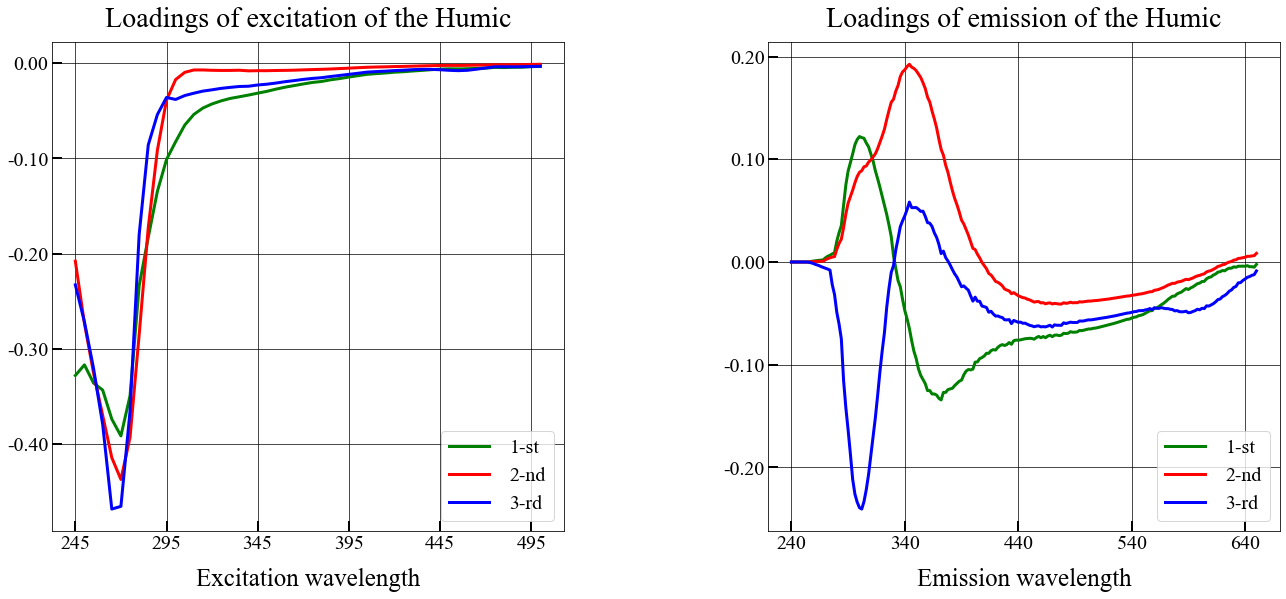

In [104]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(22, 9),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0.45)

fig_ax_1 = fg.add_subplot(gs[0,0])
#fig_ax_1.set_xlim(xmax=34)
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,0],"-",color="green",lw=3,label="1-st")
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,1],"-",color="red",lw=3,label="2-nd")
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,2],"-",color="blue",lw=3,label="3-rd")
#fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,3],"-",color="orange",lw=3,label="4-th")
#fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,4],"-",color="m",lw=3,label="5-th")
#fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,5],"-",color="c",lw=3,label="6-th")
#fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,6],"-",color="lime",lw=3,label="7-th")
#fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,7],"-",color="olive",lw=3,label="8-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Excitation wavelength",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Loadings of excitation of the Humic", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()
#fig_ax_1.set_xticklabels([int(d['Ex'][i]) for i in range(-10,50,10)], fontsize=20)
fig_ax_1.set_xticklabels([int(Xdata_numpy['excitation'][i]) for i in range(-10,60,10)], fontsize=20) #marat
fig_ax_1.set_yticklabels(sett(-50,0,5), fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,0],"-",color="green",lw=3,label="1-st")
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,1],"-",color="red",lw=3,label="2-nd")
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,2],"-",color="blue",lw=3,label="3-rd")
#fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,3],"-",color="orange",lw=3,label="4-th")
#fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,4],"-",color="m",lw=3,label="5-th")
#fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,5],"-",color="c",lw=3,label="6-th")
#fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,6],"-",color="lime",lw=3,label="7-th")
#fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,7],"-",color="olive",lw=3,label="8-th")
#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))
#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Emission wavelength",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Loadings of emission of the Humic", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()

#fig_ax_2.set_xticklabels([int(d['Em'][i]) for i in range(-20,140,20)], fontsize=20)
fig_ax_2.set_xticklabels([int(Xdata_numpy['emission'][i]) for i in range(-50,250,50)], fontsize=20) #marat
fig_ax_2.set_yticklabels(sett(-30,20,5), fontsize=20)
#fig_ax_2.set_xticklabels([i for i in range(199,502,2)][1::20], fontsize=20)
#fig_ax_2.set_xticklabels([i for i in range(190,552,40)], fontsize=20) #for asmund
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)
#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран






plt.savefig('N-PLS1_loading_all_with_centering_marat_humic.png', format='png', dpi=300)
plt.savefig("N-PLS1_loading_all_with_centering_marat_humic.svg", format="svg")

plt.show();

In [98]:
Xdata_numpy['excitation']

array([245., 250., 255., 260., 265., 270., 275., 280., 285., 290., 295.,
       300., 305., 310., 315., 320., 325., 330., 335., 340., 345., 350.,
       355., 360., 365., 370., 375., 380., 385., 390., 395., 400., 405.,
       410., 415., 420., 425., 430., 435., 440., 445., 450., 455., 460.,
       465., 470., 475., 480., 485., 490., 495., 500.])

In [97]:
Xdata_numpy.keys()

dict_keys(['X', 'emission', 'excitation'])

In [314]:
pkl.dump(
	{'emission': gridCought.best_estimator_.w_k, 
     'excitation':gridCought.best_estimator_.w_i
    },
	open('DOPA_N-PLS1_loadings_no_19_11_2021.pkl.gz', 'wb')
)

# Дальше нет актуального кода

In [68]:
Xdata_numpy['emission'][0]

240

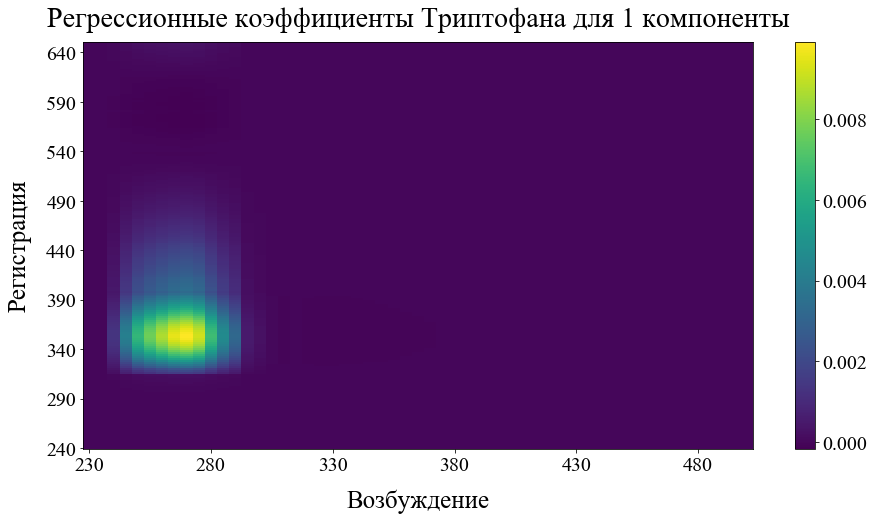

In [62]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(15, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Регрессионные коэффициенты Триптофана для 1 компоненты",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)
plt.savefig('Trp_b_npls1_full.png', format='png', dpi=300)
plt.savefig("Trp_b_npls1_full.svg", format="svg")

plt.show();

In [933]:
b_npls1_small=new_gridCought.best_estimator_.b.reshape(7,3)

In [935]:
new_gridCought.best_estimator_

Tri_PLS1_grid(n_components=5)

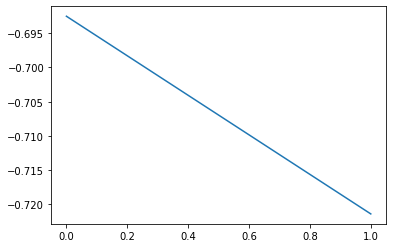

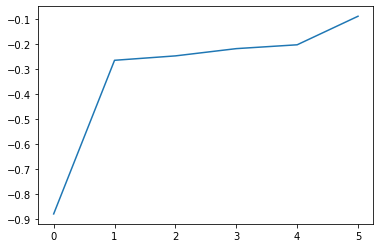

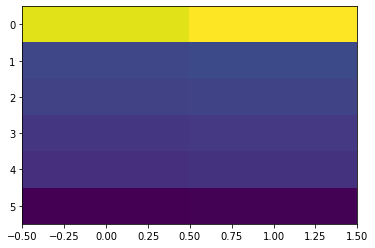

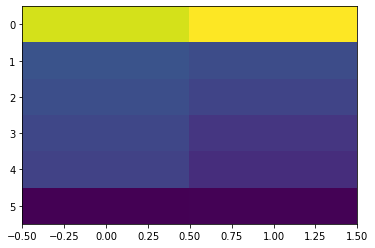

In [29]:
# для гуминовых веществ может иметь смысл взять чуть больше компонент;
# для аминокислот должно быть достаточно одного
model = Tri_PLS1_grid(n_components=1)

# NB: здесь мы ничего не центрируем, что как будто не влияет на результат
X = x_new
#X -= X.mean(axis = 0) # раскомментировать для центрирования по X

y0 = Ydata.to_numpy()[:,2] # здесь номер колонки выбирает гуминовые вещества / тирозин / триптофан
#y0 -= y0.mean() # раскомментировать для центрирования по y
model.fit(X, y0)

# почему-то массивы w_i, w_k оказываются трёхмерными, но последняя размерность всегда 1
# уберём её, чтобы работать, как мы обычно работаем с матрицами
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(model.w_i).transpose())

plt.figure()
plt.plot(flatten(model.w_k).transpose())

plt.figure()
plt.imshow(np.kron(model.w_k[0,:],model.w_i[0,:]).reshape([6,2]),aspect='auto')

plt.figure()
plt.imshow(x_new[1,:,:],aspect='auto')

In [147]:
emis=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['emission_vale_lendth']
exci=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['excitation_vale_lendth']

In [124]:
r2_cv=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final.pkl.gz', 'rb'))['r2_cv']
r2_c=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final.pkl.gz', 'rb'))['r2_c']
r2_p=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final.pkl.gz', 'rb'))['r2_p']